# 1. Imports

In [1]:
from concurrent.futures import (
    ThreadPoolExecutor,
    as_completed,
)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum
from tqdm import tqdm
from PIL import Image
import pandas as pd
import numpy as np
import cv2
import os

# 2. Constants

In [2]:
CALCULATE = False
AUGMENT = False
IMAGE_WIDTH = IMAGE_HEIGHT = 512

In [3]:
BASE_DIR = os.path.abspath("")
OUTPUT_FOLDER_PATH = os.path.join(BASE_DIR, "_output")

BASE_DIR, OUTPUT_FOLDER_PATH

('D:\\AgriNet-Research\\agrinet\\datasets\\Agriculture-Vision-2021',
 'D:\\AgriNet-Research\\agrinet\\datasets\\Agriculture-Vision-2021\\_output')

In [4]:
dataset_name = "_dataset"
dataset_path = os.path.join(BASE_DIR, dataset_name)
dataset_train_path = os.path.join(dataset_path, "train")
dataset_val_path = os.path.join(dataset_path, "val")
dataset_test_path = os.path.join(dataset_path, "test")
rgb_folder_name = 'rgbn'

In [5]:
dataset_target_path = dataset_train_path
dataset_target_path

'D:\\AgriNet-Research\\agrinet\\datasets\\Agriculture-Vision-2021\\_dataset\\train'

In [6]:
# 0 - background
LABELS = {
    1: "drydown",
    2: "nutrient_deficiency",
    3: "weed_cluster",
    4: "water",
    5: "endrow",
    6: "double_plant",
    7: "waterway",
    8: "storm_damage",
    9: "planter_skip",
}
LABELS_REVERSED = {v: k for k,v in LABELS.items()}

# 3. Verify White Pixel Presence in Label Masks

## Utils:

In [7]:
def check_pixels(
    image_array: np.ndarray, check_for_pixels: int, mode: str = "any"
) -> bool:
    """mode: any | all"""
    if mode == "any":
        return np.any(image_array == check_for_pixels)
    return np.all(image_array == check_for_pixels)


def is_blank_mask(filepath: str) -> bool:
    try:
        img = Image.open(filepath).convert("L")
        return check_pixels(
            image_array=np.array(img),
            check_for_pixels=0,  # black
            mode="all",
        )
    except FileNotFoundError:
        # Return False if the file doesnt exist
        return False


def is_label_mask(filepath: str) -> bool:
    return not is_blank_mask(filepath=filepath)


def process_label_mask(
    filename: str, labels_path: str, *, ext: str = ".png"
) -> list[int]:
    return [
        (
            1
            if is_label_mask(os.path.join(labels_path, label_name, f"{filename}{ext}"))
            else 0
        )
        for label_name in LABELS.values()
    ]


def process_label_masks_concurrent(
    target_images_paths: list[str],
    labels_path: str,
    *,
    ext: str = ".png",
    max_workers: int = None,
) -> pd.DataFrame:
    max_workers = max_workers or cpu_get_max_workers()
    data = []
    columns = ["ID"] + list(LABELS.values())

    def process_single(filepath: str):
        filename, _ = os.path.splitext(os.path.basename(filepath))
        label_results = process_label_mask(
            filename=filename, labels_path=labels_path, ext=ext
        )
        return [filename] + label_results

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = {
            executor.submit(process_single, fp): fp for fp in target_images_paths
        }
        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Processing masks",
            unit="file",
        ):
            data.append(future.result())

    return pd.DataFrame(data, columns=columns)


def cpu_get_max_workers() -> int:
    return os.cpu_count() or 1


def get_filepaths(path: str, *, exts: list[str] = []) -> list[str]:
    return [
        os.path.join(path, filename)
        for filename in os.listdir(path)
        if not exts or os.path.splitext(filename)[1] in exts
    ]

In [8]:
def _test():
    path = os.path.join(dataset_train_path, "labels", "endrow")
    mask1 = os.path.join(path, "2I4YH4WR2_1724-5674-2236-6186.png")
    mask2 = os.path.join(path, "1BFUWHD9T_2585-1539-3097-2051.png")
    assert is_label_mask(mask1) == True
    assert is_label_mask(mask2) == False
    %timeit is_label_mask(mask1)


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

1.03 ms ± 13.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
def _test():
    limit = 10
    exts = [
        ".jpg",
    ]
    path = os.path.join(dataset_target_path, "images", rgb_folder_name)
    target_images_paths = get_filepaths(path, exts=exts)[:limit]
    labels_path = os.path.join(dataset_target_path, "labels")

    df = process_label_masks_concurrent(
        target_images_paths=target_images_paths,
        labels_path=labels_path,
    )
    print(df.head())


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

Processing masks: 0file [00:00, ?file/s]

Empty DataFrame
Columns: [ID, drydown, nutrient_deficiency, weed_cluster, water, endrow, double_plant, waterway, storm_damage, planter_skip]
Index: []


## Verify:

In [10]:
def verify():
    path = os.path.join(dataset_target_path, "images", rgb_folder_name)
    target_images_paths = get_filepaths(path)
    labels_path = os.path.join(dataset_target_path, "labels")

    df = process_label_masks_concurrent(
        target_images_paths=target_images_paths,
        labels_path=labels_path,
    )

    df.to_csv(filename, index=False)

In [11]:
dn = dataset_name.replace("/", "").lower()
filename = f"{dn}_processed_masks.csv"

if CALCULATE:
    verify()
df = pd.read_csv(filename)

# 4. EDA

## Check df:

In [12]:
label_columns = df.columns[1:]  # Exclude ID
label_columns

Index(['drydown', 'nutrient_deficiency', 'weed_cluster', 'water', 'endrow',
       'double_plant', 'waterway', 'storm_damage', 'planter_skip'],
      dtype='object')

In [13]:
df.head()

ID  drydown  nutrient_deficiency  weed_cluster  \
0  11TAQJ6ET_1995-8426-2507-8938        0                    0             0   
1   11IE4DKTR_6121-684-6633-1196        0                    0             0   
2  11TAQJ6ET_1124-8510-1636-9022        0                    0             0   
3  11TAQJ6ET_1567-8177-2079-8689        0                    0             0   
4   11TAQJ6ET_1749-948-2261-1460        0                    0             0   

   water  endrow  double_plant  waterway  storm_damage  planter_skip  
0      0       0             1         0             0             0  
1      0       0             1         0             0             0  
2      0       0             1         0             0             0  
3      0       0             1         0             0             0  
4      0       0             1         0             0             0

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56944 entries, 0 to 56943
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   56944 non-null  object
 1   drydown              56944 non-null  int64 
 2   nutrient_deficiency  56944 non-null  int64 
 3   weed_cluster         56944 non-null  int64 
 4   water                56944 non-null  int64 
 5   endrow               56944 non-null  int64 
 6   double_plant         56944 non-null  int64 
 7   waterway             56944 non-null  int64 
 8   storm_damage         56944 non-null  int64 
 9   planter_skip         56944 non-null  int64 
dtypes: int64(9), object(1)
memory usage: 4.3+ MB


## Show image by ID:

In [15]:
def find_by_path(base_name: str, search_path: str) -> list:
    matching_files = []
    base_name = base_name.strip()
    for root, dirs, files in os.walk(search_path):
        for file in files:
            if os.path.splitext(file)[0] == base_name:
                matching_files.append(os.path.join(root, file))
    return matching_files


def show_image_by_id(
    image_id: str,
    search_path: str,
    *,
    max_columns: int = 3,
    exclude_blank: bool = True,
) -> None:
    matches = find_by_path(base_name=image_id, search_path=search_path)
    if exclude_blank:
        matches = [path for path in matches if not is_blank_mask(path)]
    if not (matches):
        return print(f"No matches found for image: {image_id}")

    # Calculate grid size
    n_images = len(matches)
    n_cols = min(max_columns, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten() if n_images > 1 else [axes]  # Handle single image case

    for ax, img_path in zip(axes, matches):
        img = mpimg.imread(img_path)
        ax.imshow(img)
        ax.axis("off")
        p = os.path.basename(os.path.dirname(img_path))
        f = os.path.basename(img_path)
        ax.set_title(f"{p}/{f}")

    # Hide any extra axes if the grid is larger than the number of images
    for ax in axes[len(matches) :]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

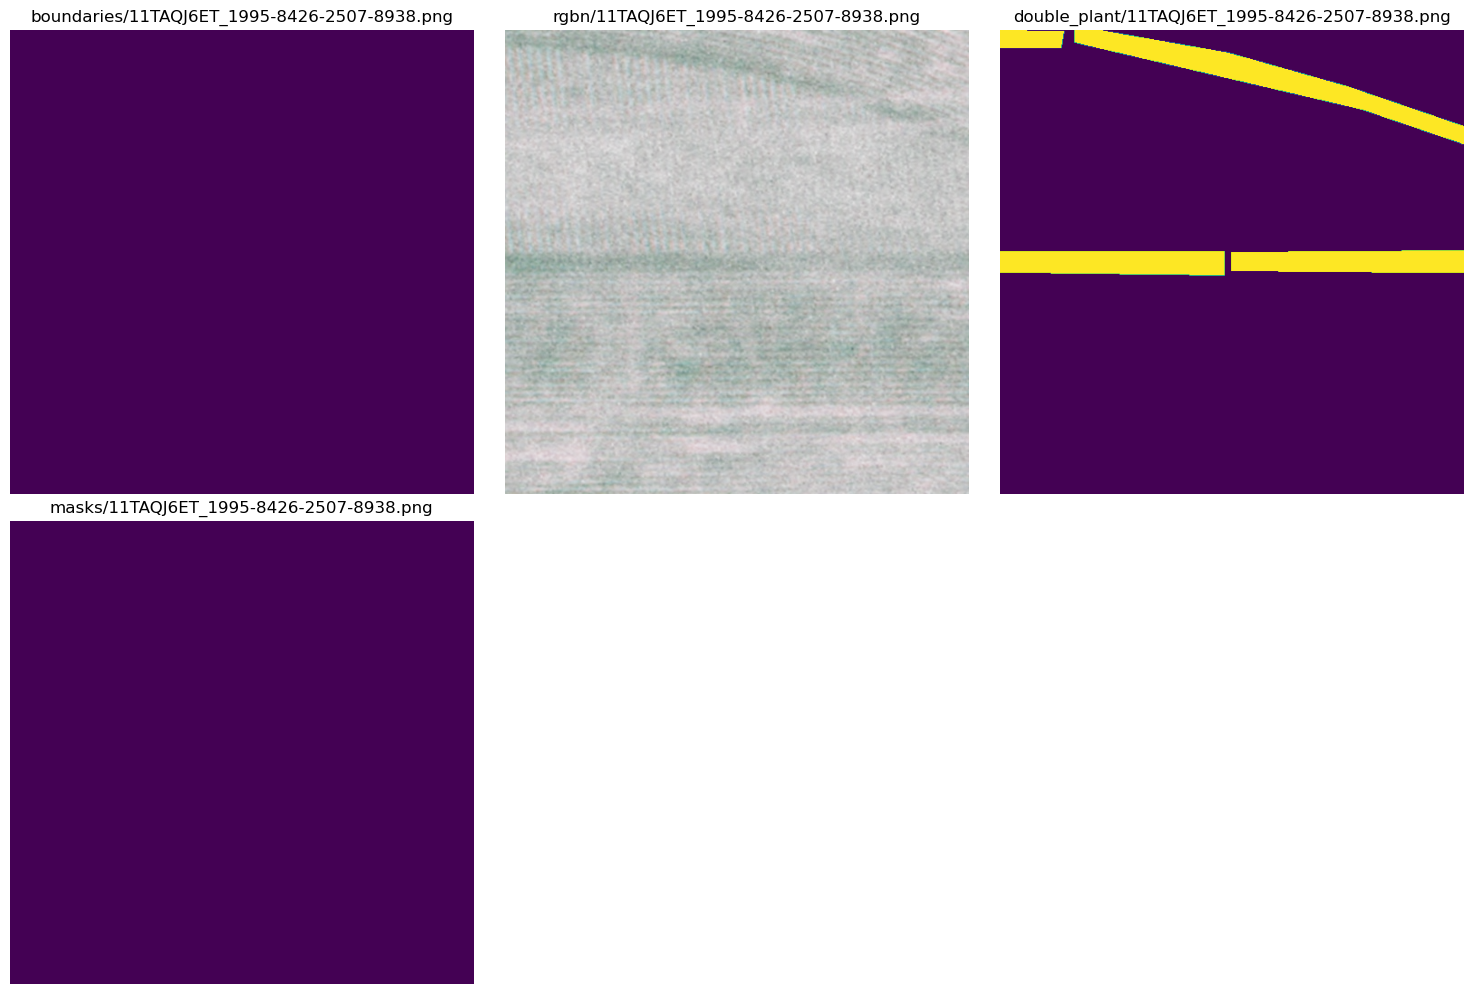

In [16]:
def _test():
    image_id = "11TAQJ6ET_1995-8426-2507-8938"
    show_image_by_id(
        image_id=image_id,
        search_path=dataset_target_path,
    )


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

## Label Counts:

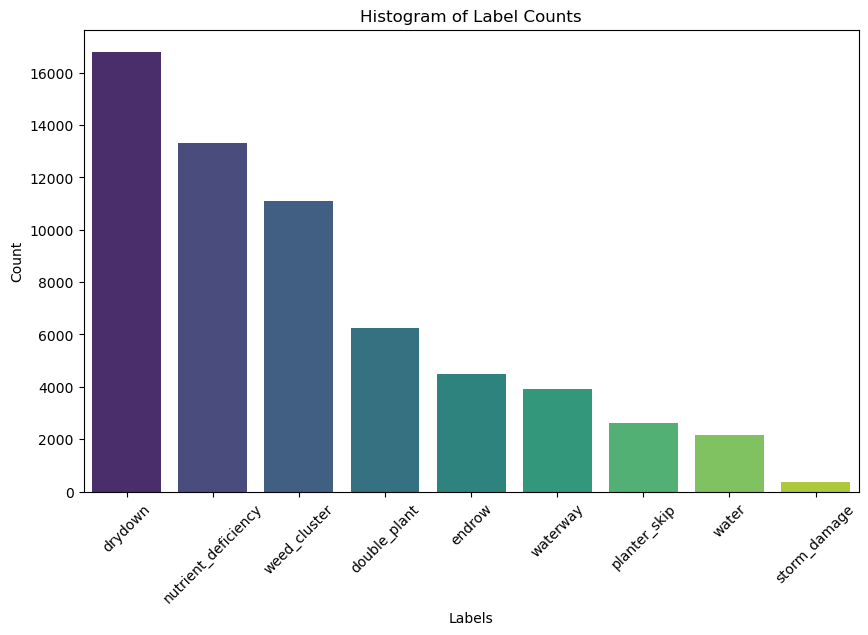

In [17]:
def show_label_counts(df: pd.DataFrame) -> None:
    label_counts = df[label_columns].sum().sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=label_counts.index,
        y=label_counts.values,
        hue=label_counts.index,
        dodge=False,
        palette="viridis",
        legend=False,
    )
    plt.title("Histogram of Label Counts")
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.show()

show_label_counts(df=df)

## Number of Classes on Image:

In [18]:
df["num_classes"] = df[label_columns].sum(axis=1)

num_classes_distribution = df["num_classes"].value_counts().sort_index().to_dict()
print(num_classes_distribution)

{1: 53356, 2: 3182, 3: 395, 4: 11}


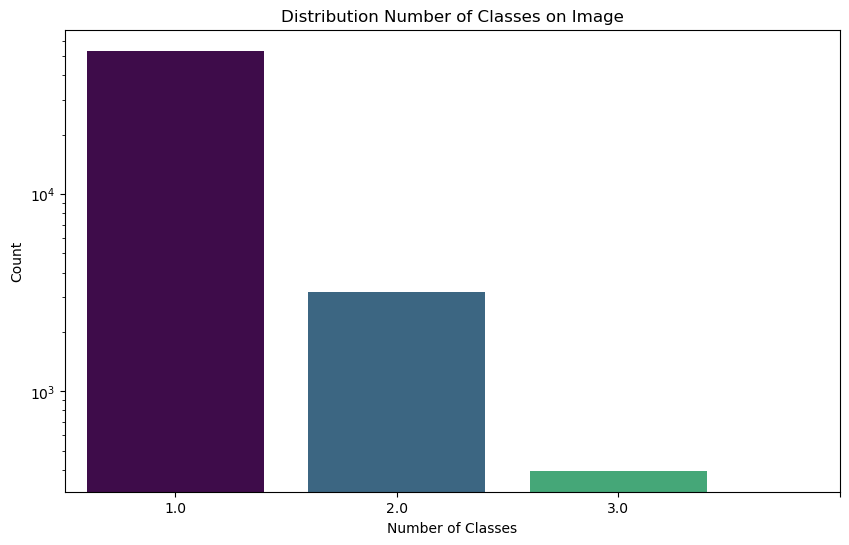

In [19]:
max_classes = df["num_classes"].max()
filtered_df = df[df["num_classes"] < max_classes]

plt.figure(figsize=(10, 6))
sns.countplot(
    data=filtered_df,
    x="num_classes",
    hue=df["num_classes"],
    palette="viridis",
    legend=False,
)
plt.title("Distribution Number of Classes on Image")
plt.xlabel("Number of Classes")
plt.ylabel("Count")
plt.yscale("log")
plt.xticks(range(max_classes))
plt.show()

## Max Number of Classes on Image:

In [20]:
df.sort_values(by="num_classes", ascending=False).head(20)

ID  drydown  nutrient_deficiency  \
35663    LWJ3IKMP1_9052-3309-9564-3821        0                    0   
28301      HWGDLXCLT_764-491-1276-1003        0                    0   
28286      HWGDLXCLT_4369-132-4881-644        0                    0   
5934     61JZ66TVX_2046-1475-2558-1987        0                    0   
5939     61JZ66TVX_2223-1293-2735-1805        0                    0   
5926     61JZ66TVX_1763-1123-2275-1635        0                    0   
10365    8NC1KY6TB_5926-8813-6438-9325        0                    0   
10376    8NC1KY6TB_6496-1994-7008-2506        0                    0   
5923     61JZ66TVX_1685-3304-2197-3816        0                    0   
5928     61JZ66TVX_1919-3384-2431-3896        0                    0   
35664    LWJ3IKMP1_9251-3137-9763-3649        0                    0   
7857   7C2TI62TD_2734-12147-3246-12659        0                    0   
2980     2I4YH4WR2_7535-5659-8047-6171        0                    1   
2981       2I4YH4WR2_7907-448-8419-960        0                    1   
2994       2I4YH4WR2_8256-338-8768-850        0                    1   
36244  MJVEPTAAY_5363-11490-5875-12002        0                    0   
28139   HQIAQEHIP_10445-702-10957-1214        0                    0   
3972   3DNDI4684_10383-5876-10895-6388        0                    0   
2996       2I4YH4WR2_8535-297-9047-809        0                    1   
36242  MJVEPTAAY_4851-11490-5363-12002        0                    0   

       weed_cluster  water  endrow  double_plant  waterway  storm_damage  \
35663             1      0       1             1         0             0   
28301             1      0       1             1         0             0   
28286             1      0       1             1         0             0   
5934              1      1       1             1         0             0   
5939              1      1       1             1         0             0   
5926              1      1       1             1         0             0   
10365             1      0       1             1         0             0   
10376             1      0       1             1         0             0   
5923              1      1       1             1         0             0   
5928              1      1       1             1         0             0   
35664             1      0       1             1         0             0   
7857              1      0       1             1         0             0   
2980              0      0       1             1         0             0   
2981              0      0       1             1         0             0   
2994              0      0       1             1         0             0   
36244             0      0       1             1         0             0   
28139             0      0       1             1         0             0   
3972              0      0       1             1         0             0   
2996              0      0       1             1         0             0   
36242             0      0       1             1         0             0   

       planter_skip  num_classes  
35663             1            4  
28301             1            4  
28286             1            4  
5934              0            4  
5939              0            4  
5926              0            4  
10365             1            4  
10376             1            4  
5923              0            4  
5928              0            4  
35664             1            4  
7857              0            3  
2980              0            3  
2981              0            3  
2994              0            3  
36244             1            3  
28139             1            3  
3972              1            3  
2996              0            3  
36242             1            3

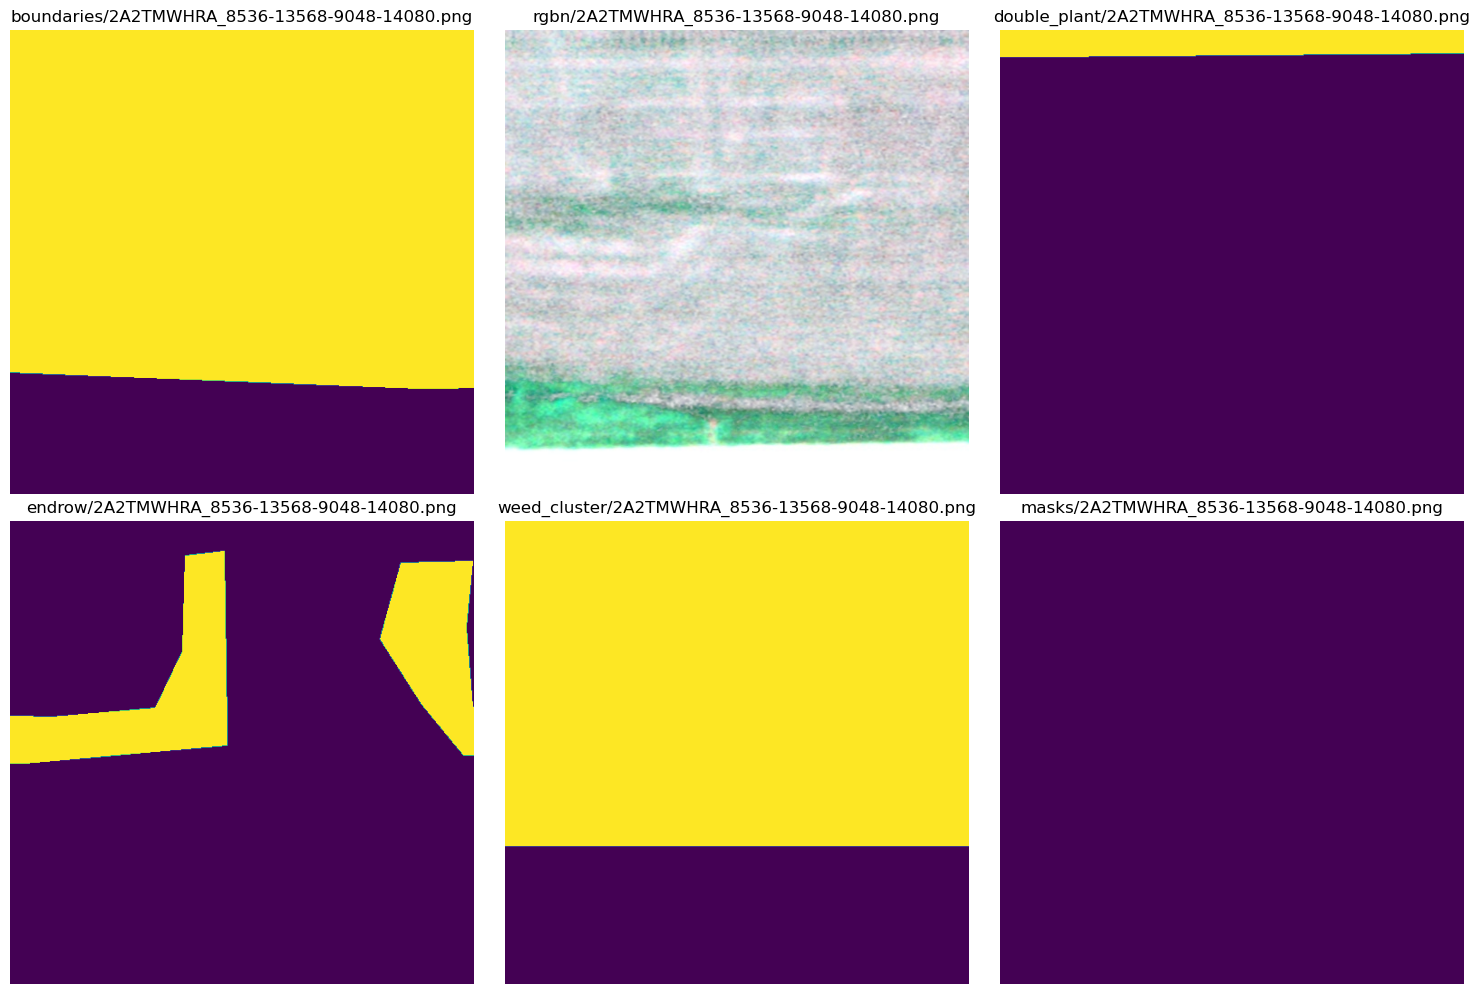

In [21]:
show_image_by_id(
    image_id="2A2TMWHRA_8536-13568-9048-14080",
    search_path=dataset_target_path,
)

## Correlation:

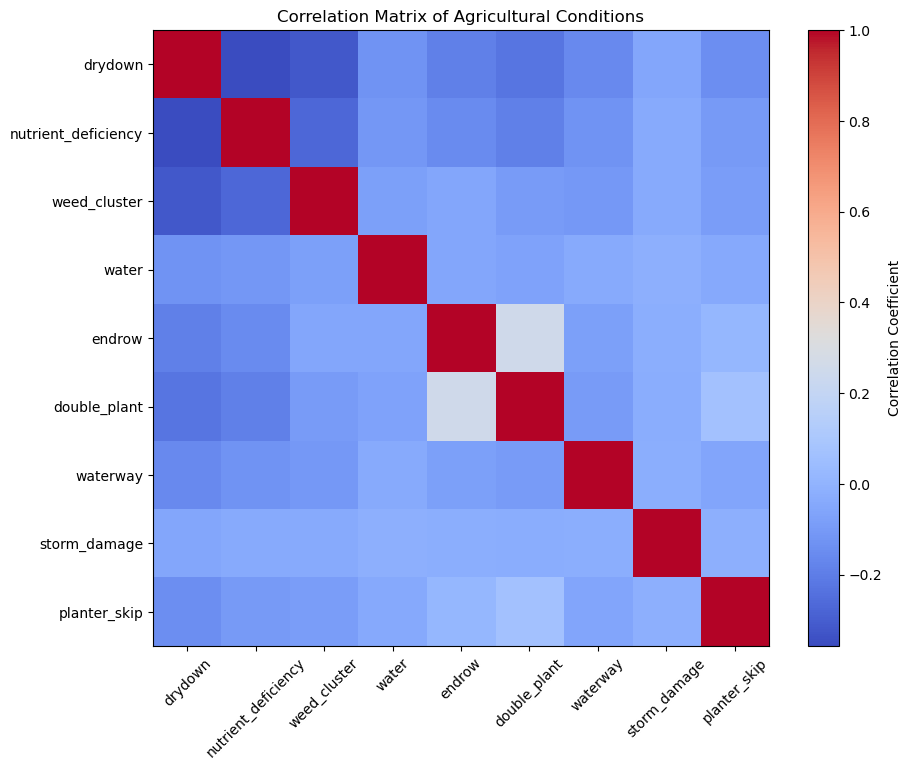

In [22]:
correlations = df[label_columns].corr()

plt.figure(figsize=(10, 8))
plt.imshow(correlations, cmap="coolwarm", interpolation="none")
plt.colorbar(label="Correlation Coefficient")
plt.xticks(range(len(label_columns)), label_columns, rotation=45)
plt.yticks(range(len(label_columns)), label_columns)
plt.title("Correlation Matrix of Agricultural Conditions")
plt.show()

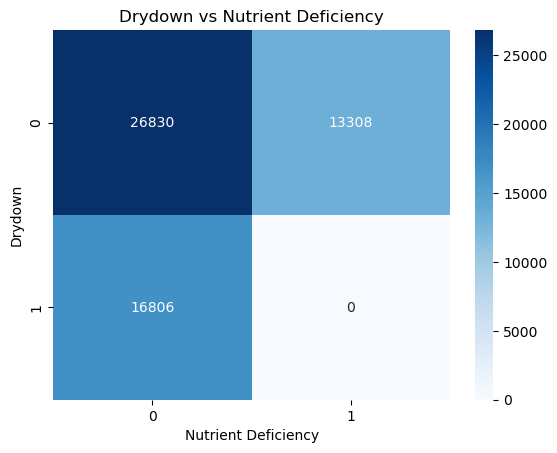

In [23]:
sns.heatmap(
    pd.crosstab(df["drydown"], df["nutrient_deficiency"]),
    annot=True,
    fmt="d",
    cmap="Blues",
)
plt.title("Drydown vs Nutrient Deficiency")
plt.ylabel("Drydown")
plt.xlabel("Nutrient Deficiency")
plt.show()

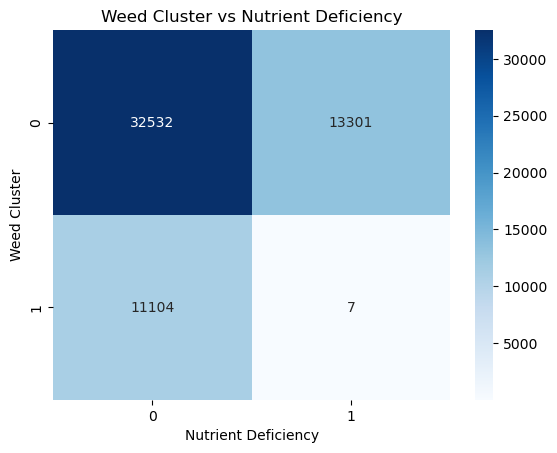

In [24]:
sns.heatmap(
    pd.crosstab(df["weed_cluster"], df["nutrient_deficiency"]),
    annot=True,
    fmt="d",
    cmap="Blues",
)
plt.title("Weed Cluster vs Nutrient Deficiency")
plt.ylabel("Weed Cluster")
plt.xlabel("Nutrient Deficiency")
plt.show()

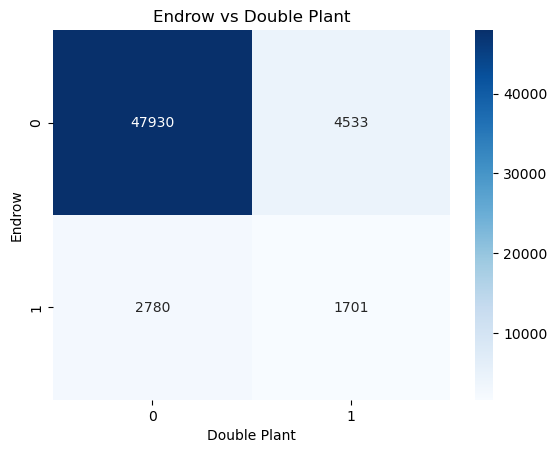

In [25]:
sns.heatmap(
    pd.crosstab(df["endrow"], df["double_plant"]), annot=True, fmt="d", cmap="Blues"
)
plt.title("Endrow vs Double Plant")
plt.ylabel("Endrow")
plt.xlabel("Double Plant")
plt.show()

Most conditions show weak correlations, suggesting they occur independently.

Notable moderate correlations exist, such as between nutrient_deficiency and drydown, endrow and double_plant.

# 5. Balancing dataset classes

**Input Data Structure for augmentation**

Image: 4-channel images (RGB + NIR). RGBA (.png)

Mask: Multi-class masks where each pixel represents a class label. 0 - class1, 1 - class2...

## Pre-processing (RGB+NIR -> RGBN)

In [26]:
images_path = os.path.join(dataset_target_path, "images")
rgb_images_path = os.path.join(images_path, rgb_folder_name)
nir_images_path = os.path.join(images_path, "nir")
rgb_images_path

'D:\\AgriNet-Research\\agrinet\\datasets\\Agriculture-Vision-2021\\_dataset\\train\\images\\rgbn'

### Utils:

In [27]:
def _show_rgbn_image_as_rgb_and_nir(rgbn: np.ndarray) -> None:
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # RGB Visualization
    axs[0].imshow(rgbn[..., :3])
    axs[0].set_title("RGB")
    axs[0].axis("off")

    # NIR Visualization
    axs[1].imshow(rgbn[..., 3], cmap="gray")
    axs[1].set_title("NIR")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()


def _show_rgbn_image_by_channels(rgbn: np.ndarray) -> None:
    channels = "RGB"
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    for i, channel in enumerate(channels):
        axs[i].imshow(rgbn[..., i], cmap="gray")
        axs[i].set_title(channel)
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


def save_rgbn_image(rgbn_image: np.ndarray, output_path: str) -> str:
    """Save as a .png file (4 channels)"""
    filename, _ = os.path.splitext(output_path)
    output_path = f"{filename}.png"
    cv2.imwrite(output_path, cv2.cvtColor(rgbn_image, cv2.COLOR_RGBA2BGRA))
    return output_path


def load_rgbn_image(path: str) -> np.ndarray:
    rgbn_image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    return rgbn_image


def get_rgbn_image(
    nir_image_path: str,
    rgb_image_path: str,
) -> np.ndarray | None:
    if not all([os.path.exists(i) for i in [nir_image_path, rgb_image_path]]):
        return

    nir_image = cv2.imread(nir_image_path, cv2.IMREAD_GRAYSCALE)
    rgb_image = cv2.imread(rgb_image_path, cv2.IMREAD_COLOR)

    # Resize NIR image to match the RGB image, if necessary
    nir_image = cv2.resize(nir_image, (rgb_image.shape[1], rgb_image.shape[0]))

    # Merge the RGB image with NIR (creating a 4-channel image)
    rgbn = np.dstack((rgb_image, nir_image))
    return rgbn

In [28]:
def _test():
    image_name = "11TAQJ6ET_1995-8426-2507-8938.jpg"

    nir_image_path = os.path.join(nir_images_path, image_name)
    rgb_image_path = os.path.join(rgb_images_path, image_name)

    %timeit -n 10 get_rgbn_image(nir_image_path=nir_image_path, rgb_image_path=rgb_image_path)

    rgbn = get_rgbn_image(
        nir_image_path=nir_image_path,
        rgb_image_path=rgb_image_path,
    )
    if rgbn is None:
        raise AssertionError(f"Failed load nir + rgb for image {image_name}")

    # Save and load image
    output_path = os.path.join(OUTPUT_FOLDER_PATH, image_name)
    path = save_rgbn_image(rgbn, output_path=output_path)
    rgbn = load_rgbn_image(path)
    print(rgbn.shape)

    _show_rgbn_image_as_rgb_and_nir(rgbn=rgbn)
    _show_rgbn_image_by_channels(rgbn=rgbn)


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

47.2 μs ± 16.5 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Failed pass all test: Failed load nir + rgb for image 11TAQJ6ET_1995-8426-2507-8938.jpg


### Pre-processing:

In [29]:
# Create folder for rgbn images
rgbn_images_path = os.path.join(images_path, "rgbn")
os.makedirs(rgbn_images_path, exist_ok=True)
rgbn_images_path

'D:\\AgriNet-Research\\agrinet\\datasets\\Agriculture-Vision-2021\\_dataset\\train\\images\\rgbn'

In [30]:
def process_single_image(image_name: str) -> str:
    output_path = os.path.join(rgbn_images_path, image_name)
    rgbn = get_rgbn_image(
        nir_image_path=os.path.join(nir_images_path, image_name),
        rgb_image_path=os.path.join(rgb_images_path, image_name),
    )
    path = save_rgbn_image(rgbn, output_path=output_path)
    return path


def pre_processing():
    images = os.listdir(rgb_images_path)
    with ThreadPoolExecutor() as executor:
        futures = {
            executor.submit(process_single_image, image_name): image_name
            for image_name in images
        }
        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Processing images",
            unit="image",
        ):
            try:
                future.result()
            except Exception as e:
                print(f"Error processing {futures[future]}: {e}")


if CALCULATE:
    pre_processing()

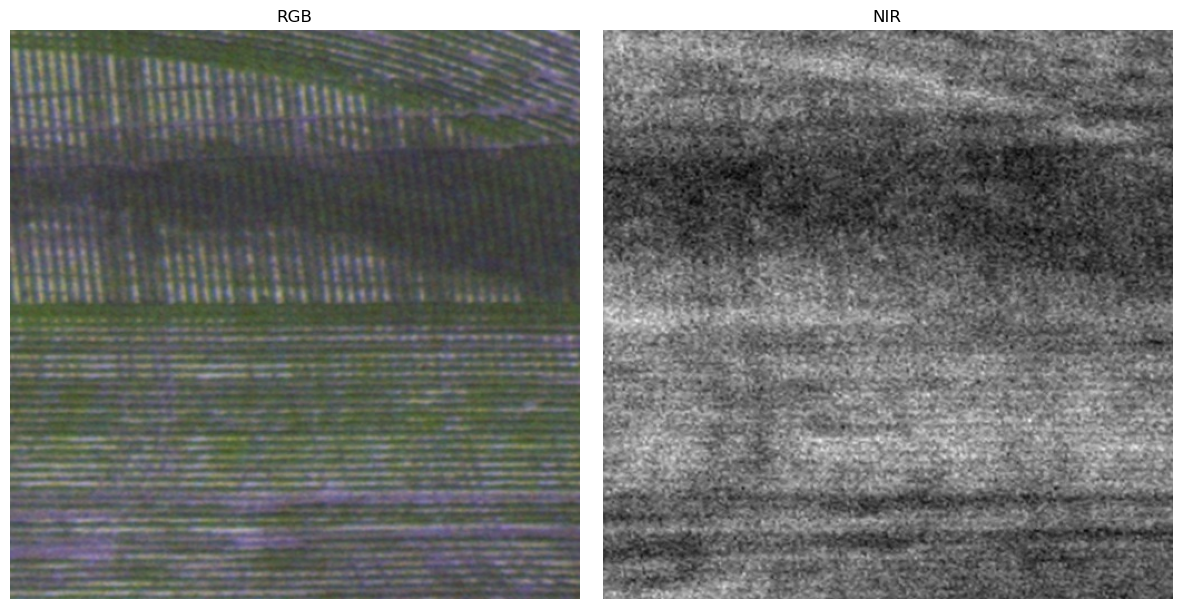

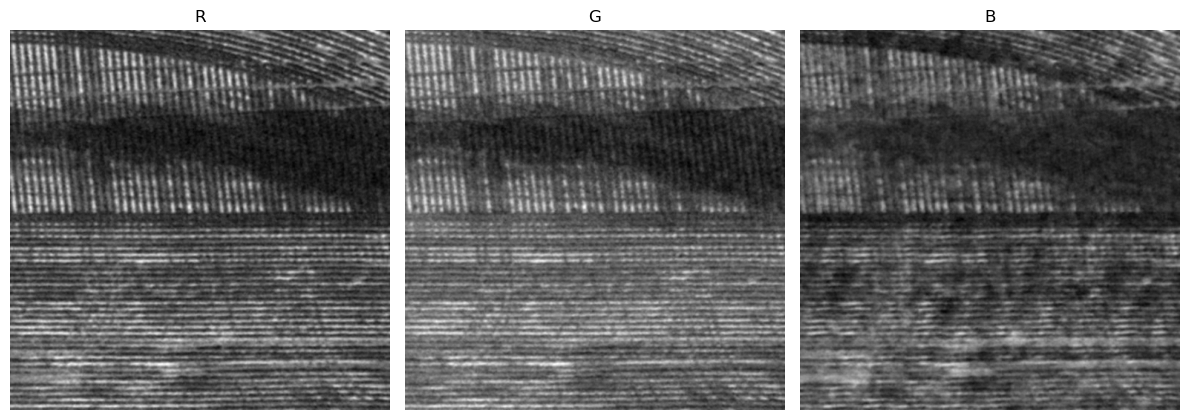

In [31]:
# load pre-processed image
image_name = "11TAQJ6ET_1995-8426-2507-8938.png"
path = os.path.join(rgbn_images_path, image_name)

rgbn = load_rgbn_image(path)
_show_rgbn_image_as_rgb_and_nir(rgbn=rgbn)
_show_rgbn_image_by_channels(rgbn=rgbn)

## Pre-processing (Labels -> Multi-label masks)

In [32]:
labels_path = os.path.join(dataset_target_path, "labels")

### Utils:

In [33]:
def _show_multiclass_mask(mask: np.ndarray) -> None:
    plt.imshow(mask, cmap="tab20", interpolation="nearest")
    plt.colorbar(label="Class Label")
    plt.title("Multi-Class Image Mask")
    plt.axis("off")
    plt.show()


def get_masks(mask_name: str, labels_path: str) -> dict:
    masks = {}
    for label_index, label_name in LABELS.items():
        mask_path = os.path.join(labels_path, label_name, mask_name)
        if os.path.exists(mask_path):
            mask = np.array(Image.open(mask_path))
            masks[label_index] = np.where(mask > 0, 1, 0)
        else:
            print(f"Failed find the mask {mask_name} in {labels_path}")
            masks[label_index] = np.zeros((IMAGE_WIDTH, IMAGE_HEIGHT), dtype=np.uint8)

    return masks


def get_merged_mask(mask_name: str, labels_path: str) -> np.ndarray:
    merged_mask = None
    masks = get_masks(mask_name, labels_path)

    for label_index, class_mask in masks.items():
        class_mask = class_mask * label_index
        if merged_mask is not None:
            merged_mask = np.where(class_mask > 0, class_mask, merged_mask)
        else:
            merged_mask = class_mask

    return merged_mask

def save_masks(masks: list[np.ndarray], filename:str, labels_path: str) -> None:
    """masks must be sorted in LABELS ordering"""
    for mask, label_name in zip(masks, LABELS.values()):
        output_path = os.path.join(labels_path, label_name, filename)
        cv2.imwrite(output_path, mask)
        

def merge_masks(masks: list[np.ndarray]) -> np.ndarray:
    merged_mask = None

    for label_index, class_mask in zip(LABELS.keys(), masks):
        class_mask = class_mask * label_index
        if merged_mask is not None:
            merged_mask = np.where(class_mask > 0, class_mask, merged_mask)
        else:
            merged_mask = class_mask

    return merged_mask

(512, 512)


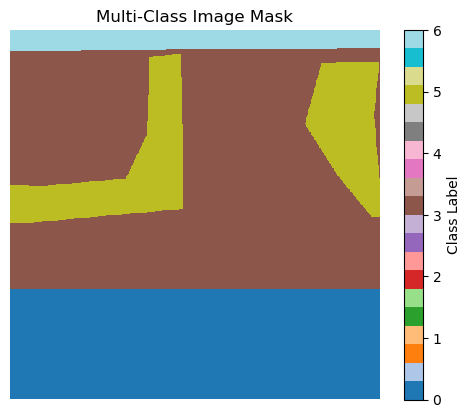

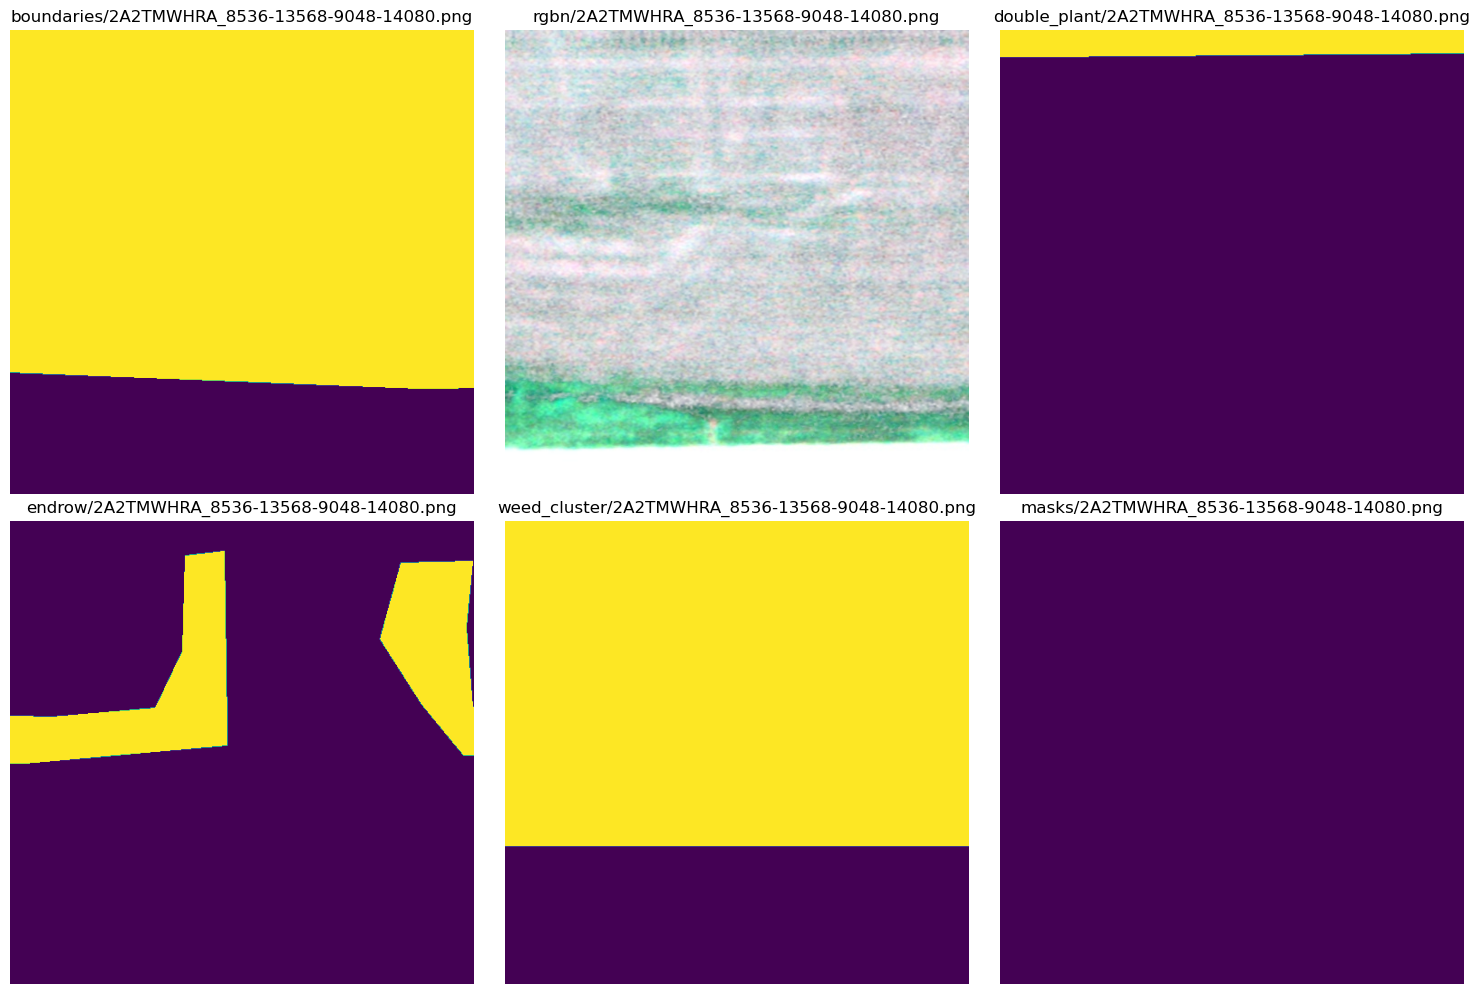

In [34]:
def _test():
    mask_name = "2A2TMWHRA_8536-13568-9048-14080.png"
    image_id, _ = os.path.splitext(mask_name)
    mask = get_merged_mask(mask_name=mask_name, labels_path=labels_path)
    print(mask.shape)

    _show_multiclass_mask(mask=mask)

    show_image_by_id(
        image_id=image_id,
        search_path=dataset_target_path,
    )


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

(512, 512)


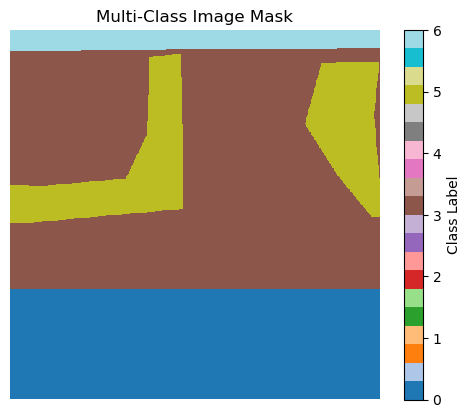

In [35]:
def _test():
    mask_name = "2A2TMWHRA_8536-13568-9048-14080.png"
    path = os.path.join(OUTPUT_FOLDER_PATH, 'labels')
    
    masks = get_masks(mask_name=mask_name, labels_path=labels_path).values()
    save_masks(masks, mask_name, path)
    masks = get_masks(mask_name=mask_name, labels_path=path).values()
    mask = merge_masks(masks=masks)
    print(mask.shape)

    _show_multiclass_mask(mask=mask)


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

## Augmentation

## Utils

In [36]:
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2
import albumentations as A

C:\Users\Max\miniconda3\envs\agrinet\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [37]:
def get_modificators(p: int = 1) -> tuple:
    return (
        A.HorizontalFlip(p=p),
        A.VerticalFlip(p=p),
        A.RandomRotate90(p=p),
        A.ElasticTransform(p=p),
        A.GridDistortion(p=p),
        A.RandomBrightnessContrast(p=p),
        A.RandomSizedCrop(
            min_max_height=(int(IMAGE_HEIGHT * p), IMAGE_HEIGHT),
            height=IMAGE_HEIGHT,
            width=IMAGE_WIDTH,
            p=0.5,
        ),
        A.GaussianBlur(blur_limit=(3, 7), p=p),
    )

train_transform = A.Compose(get_modificators(p=0.5))

# generate transforms for each modifier
train_transforms = [A.Compose([m,]) for m in get_modificators()]

train_transforms[:2]
    

[Compose([
   HorizontalFlip(p=1.0),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True),
 Compose([
   VerticalFlip(p=1.0),
 ], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)]

(512, 512, 4) | 9 masks
The slowest run took 169.32 times longer than the fastest. This could mean that an intermediate result is being cached.
242 ms ± 202 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(512, 512, 4) | 9 masks


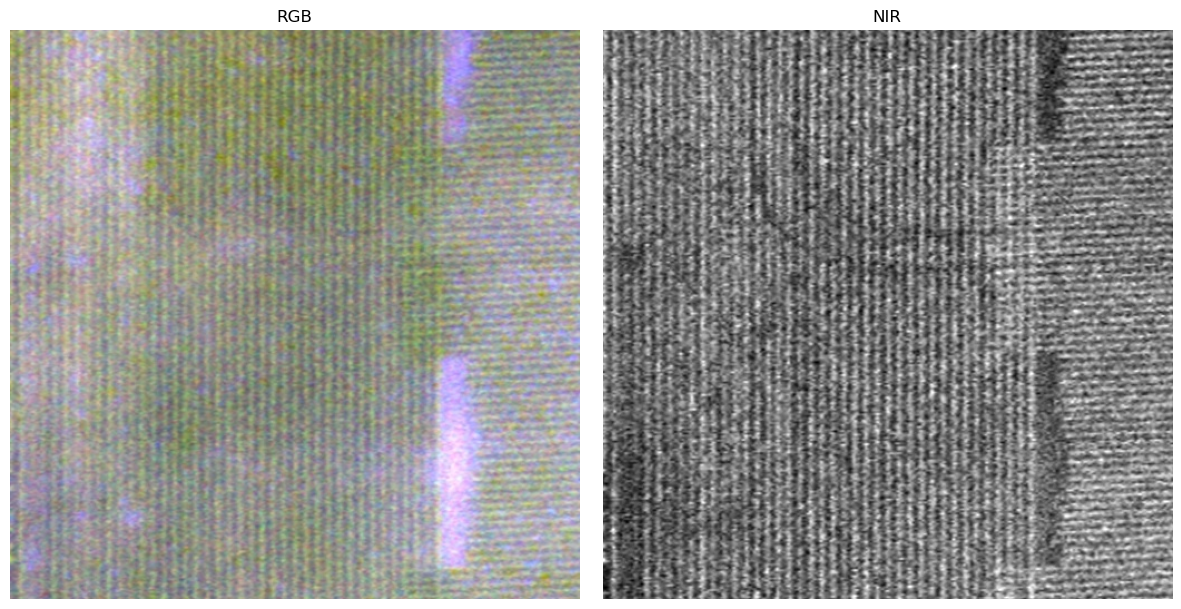

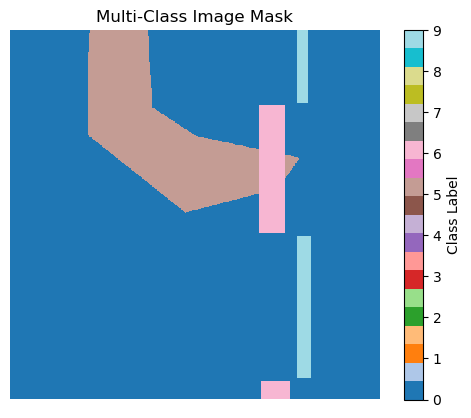

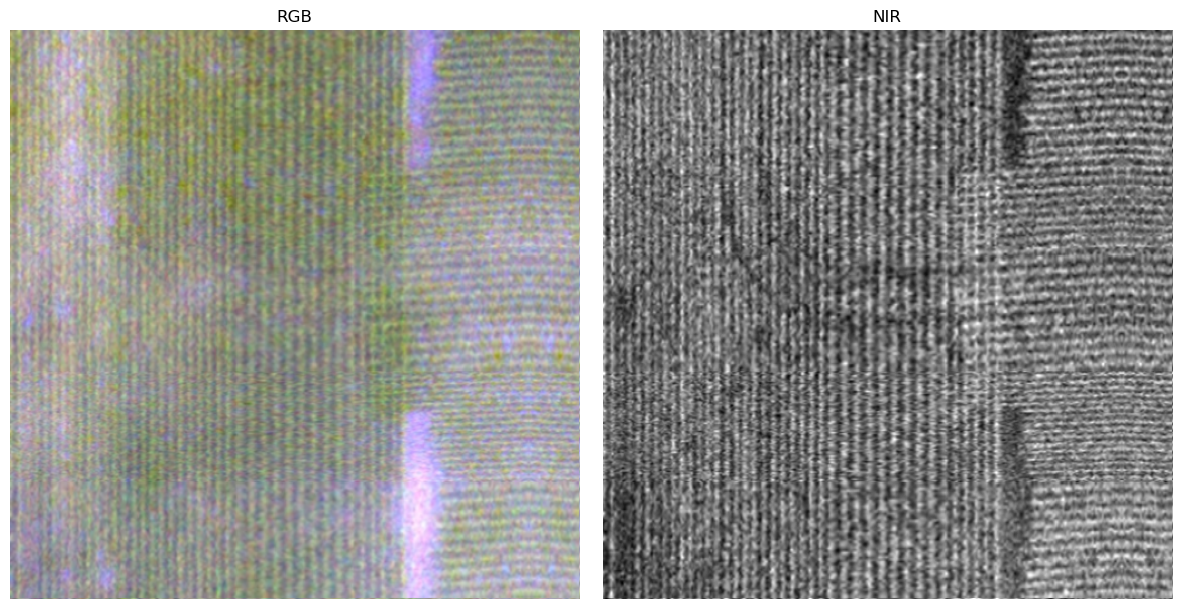

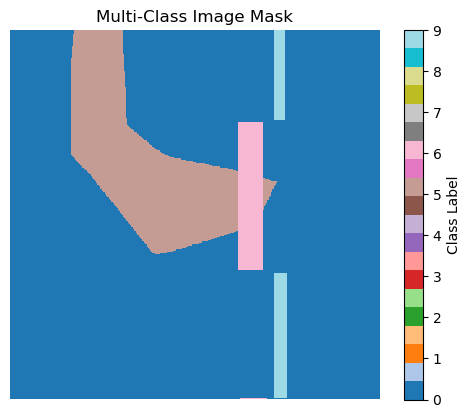

In [38]:
def augment(
    image: np.ndarray,
    masks: list[np.ndarray],
    *,
    transform: A.Compose | None = None,
) -> tuple[np.ndarray, list[np.ndarray]]:
    if transform is None:
        raise Exception("Transform required")
    augmented = transform(image=image, masks=list(masks))
    augmented_image = augmented["image"]
    augmented_masks = augmented["masks"]
    return (augmented_image, augmented_masks)


def _test():
    image_name = "HQIAQEHIP_908-3589-1420-4101.png"
    path = os.path.join(rgbn_images_path, image_name)

    rgbn = load_rgbn_image(path)
    masks = get_masks(mask_name=image_name, labels_path=labels_path).values()
    mask = merge_masks(masks=masks)
    print(rgbn.shape, "|", f"{len(masks)} masks")

    %timeit -n 1 augment(image=rgbn, masks=masks, transform=train_transform)

    augmented_rgbn, augmented_masks = augment(
        image=rgbn,
        masks=masks,
        transform=train_transform,
    )
    augmented_mask = merge_masks(masks=augmented_masks)
    print(augmented_rgbn.shape, "|", f"{len(augmented_masks)} masks")

    _show_rgbn_image_as_rgb_and_nir(rgbn=rgbn)
    _show_multiclass_mask(mask=mask)
    _show_rgbn_image_as_rgb_and_nir(rgbn=augmented_rgbn)
    _show_multiclass_mask(mask=augmented_mask)


try:
    _test()
except AssertionError as e:
    print(f"Failed pass all test: {e}")
except Exception as e:
    print(f"Error: {e}")

## Processing augmentation

In [39]:
# init path
dataset_augment_images_path = os.path.join(dataset_target_path, 'aug_images')
dataset_augment_labels_path = os.path.join(dataset_target_path, 'aug_labels')
dataset_augment_images_rgbn_path = os.path.join(dataset_augment_images_path, 'rgbn')
dataset_augment_images_nir_path = os.path.join(dataset_augment_images_path, 'nir')

dataset_augment_images_rgbn_path

'D:\\AgriNet-Research\\agrinet\\datasets\\Agriculture-Vision-2021\\_dataset\\train\\aug_images\\rgbn'

In [40]:
# generate folders
os.makedirs(dataset_augment_images_rgbn_path, exist_ok=True)
for label in LABELS.values():
    label_path = os.path.join(dataset_augment_labels_path, label)
    os.makedirs(label_path, exist_ok=True)

In [41]:
def get_coefficients() -> dict:
    label_counts = dict(df[label_columns].sum().sort_values(ascending=False))
    max_count = max(label_counts.values())
    
    coefficients = {}
    for label, count in label_counts.items():
        if count < max_count:
            k = np.ceil((max_count - count) / count).astype(int)
            coefficients[label] = k
        else:
            coefficients[label] = 0
    return coefficients

get_coefficients()

{'drydown': 0,
 'nutrient_deficiency': 1,
 'weed_cluster': 1,
 'double_plant': 2,
 'endrow': 3,
 'waterway': 4,
 'planter_skip': 6,
 'water': 7,
 'storm_damage': 47}

In [42]:
def get_image_names_by_label_name(label_name: str) -> list:
    result = df.loc[df[label_name] == 1, 'ID']
    return [f"{i}.png" for i in result] 

len(get_image_names_by_label_name("water"))

2155

In [43]:
def process_image(image_name, label_name, transform, rgbn_images_path, labels_path, dataset_augment_images_rgbn_path, dataset_augment_labels_path):
    """Process and augment a single image."""
    # Load image and masks
    path = os.path.join(rgbn_images_path, image_name)
    rgbn = load_rgbn_image(path)
    masks = get_masks(mask_name=image_name, labels_path=labels_path).values()

    # Augment image and masks
    augmented_rgbn, augmented_masks = augment(
        image=rgbn,
        masks=masks,
        transform=transform,
    )

    # Generate new name
    name, ext = os.path.splitext(image_name)
    transform_name = transform.transforms[0].__class__.__name__.lower()
    new_image_name = f"{name}_{label_name}_{transform_name}{ext}"

    # Save image and masks
    save_rgbn_image(augmented_rgbn, os.path.join(dataset_augment_images_rgbn_path, new_image_name))
    save_masks(augmented_masks, new_image_name, dataset_augment_labels_path)

    return new_image_name


def augment_images(limit:int | None = None):
    tasks = []
    with ThreadPoolExecutor() as executor:
        for label_name, k in get_coefficients().items():
            image_names = get_image_names_by_label_name(label_name)
    
            if limit:
                image_names = image_names[:limit]
    
            for transform in train_transforms[:k]:
                for image_name in image_names:
                    tasks.append((
                        executor.submit(
                            process_image,
                            image_name,
                            label_name,
                            transform,
                            rgbn_images_path,
                            labels_path,
                            dataset_augment_images_rgbn_path,
                            dataset_augment_labels_path,
                        ),
                        label_name,
                    ))
    
        # Use tqdm to show progress
        with tqdm(total=len(tasks), desc="Processing images") as pbar:
            for future, label_name in tasks:
                new_image_name = future.result()  # Wait for the task to complete
                pbar.set_postfix(label=label_name, image=new_image_name)
                pbar.update(1)

if AUGMENT: 
    augment_images()

In [44]:
def verify_aug():
    path = os.path.join(dataset_target_path, "aug_images", rgb_folder_name)
    target_images_paths = get_filepaths(path)
    labels_path = os.path.join(dataset_target_path, "aug_labels")

    df = process_label_masks_concurrent(
        target_images_paths=target_images_paths,
        labels_path=labels_path,
    )

    df.to_csv(filename, index=False)

dn = dataset_name.replace("/", "").lower()
filename = f"{dn}_processed_aug_masks.csv"
if CALCULATE: verify_aug()
df_aug = pd.read_csv(filename)

# EDA (data + augmentation)

In [45]:
df = pd.concat([df, df_aug], ignore_index=True)

# update number of classes
df["num_classes"] = df[label_columns].sum(axis=1)
num_classes_distribution = df["num_classes"].value_counts().sort_index().to_dict()
print(num_classes_distribution)

{1: 132591, 2: 19760, 3: 3898, 4: 148}


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156397 entries, 0 to 156396
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ID                   156397 non-null  object
 1   drydown              156397 non-null  int64 
 2   nutrient_deficiency  156397 non-null  int64 
 3   weed_cluster         156397 non-null  int64 
 4   water                156397 non-null  int64 
 5   endrow               156397 non-null  int64 
 6   double_plant         156397 non-null  int64 
 7   waterway             156397 non-null  int64 
 8   storm_damage         156397 non-null  int64 
 9   planter_skip         156397 non-null  int64 
 10  num_classes          156397 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 13.1+ MB


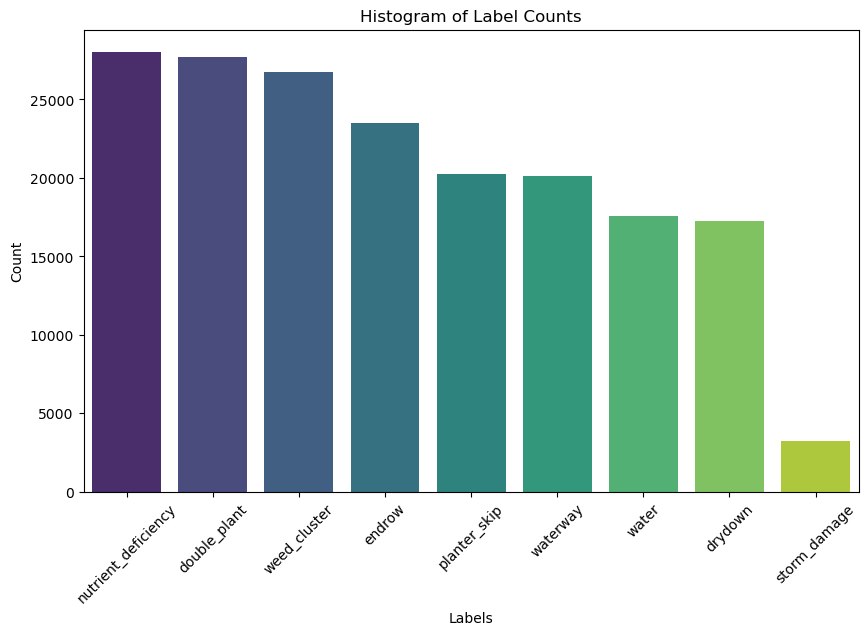

In [47]:
show_label_counts(df=df)

In [49]:
#TODO drop storm_damage, filter about 15-17k images and create new csv for train nn